In [38]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/user/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv_lche329_DTC9to1').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.classification import LogisticRegression

In [39]:
# Read in the CSV data.
data = spark.read.load('./Sales_data/sales_en.csv',format='csv',header='true',inferSchema = True)

In [40]:
# Print data schema.
data.printSchema()

# Print data columns.
data.columns

root
 |-- ID: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Sales Representative: string (nullable = true)
 |-- Hospital Name: string (nullable = true)
 |-- Hospital Attribute: string (nullable = true)
 |-- Hospital Code: string (nullable = true)
 |-- Purchasing Price: double (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- IMF: string (nullable = true)
 |-- Hospital Class: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Client Name: string (nullable = true)
 |-- Sales Volume: double (nullable = true)
 |-- Profits: double (nullable = true)
 |-- Satisfaction: string (nullable = true)



['ID',
 'Year',
 'Product Name',
 'Unit',
 'Region',
 'Sales Representative',
 'Hospital Name',
 'Hospital Attribute',
 'Hospital Code',
 'Purchasing Price',
 'Selling Price',
 'IMF',
 'Hospital Class',
 'Department',
 'Client Name',
 'Sales Volume',
 'Profits',
 'Satisfaction']

In [41]:
# Select a list of relevant columns. 
# Profits, for example, should not be celected
# As the target 'Satisfaction' derives from 'Profits'
my_cols = data.select(['Satisfaction',
 'Sales Representative',
 'Hospital Attribute',
 'Selling Price',
 'Hospital Class',
 'Department',
 'Sales Volume'])
my_cols.dtypes

[('Satisfaction', 'string'),
 ('Sales Representative', 'string'),
 ('Hospital Attribute', 'string'),
 ('Selling Price', 'double'),
 ('Hospital Class', 'string'),
 ('Department', 'string'),
 ('Sales Volume', 'double')]

In [42]:
my_final_data = my_cols

In [43]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [44]:
# First create a string indexer (convert every string into a number, such as male = 0 and female = 1).
# A number will be assigned to every category in the column.
Sales_Representative_indexer = StringIndexer(inputCol='Sales Representative',outputCol='Sales_Representative_Index')

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# This makes it easier to process when you have multiple classes.
Sales_Representative_encoder = OneHotEncoder(inputCol='Sales_Representative_Index',outputCol='Sales_Representative_Vec')

In [45]:
Hospital_Attribute_indexer = StringIndexer(inputCol='Hospital Attribute',outputCol='Hospital_Attribute_Index')
Hospital_Attribute_encoder = OneHotEncoder(inputCol='Hospital_Attribute_Index',outputCol='Hospital_Attribute_Vec')

In [46]:
Hospital_Class_indexer = StringIndexer(inputCol='Hospital Class',outputCol='Hospital_Class_Index')
Hospital_Class_encoder = OneHotEncoder(inputCol='Hospital_Class_Index',outputCol='Hospital_Class_Vec')

In [47]:
Department_indexer = StringIndexer(inputCol='Department',outputCol='Department_Index')
Department_encoder = OneHotEncoder(inputCol='Department_Index',outputCol='Department_Vec')

In [48]:
Satisfaction_indexer = StringIndexer(inputCol='Satisfaction',outputCol='Satisfaction_Index')
#Satisfaction_encoder = OneHotEncoder(inputCol='Satisfaction_Index',outputCol='Satisfaction_Vec')
my_final_data_indexed = Satisfaction_indexer.fit(my_final_data).transform(my_final_data)
my_final_data_indexed.printSchema()


root
 |-- Satisfaction: string (nullable = true)
 |-- Sales Representative: string (nullable = true)
 |-- Hospital Attribute: string (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- Hospital Class: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Sales Volume: double (nullable = true)
 |-- Satisfaction_Index: double (nullable = true)



In [49]:
# Now we can assemble all of this as one vector in the features column.
assembler = VectorAssembler(inputCols=['Sales_Representative_Vec',
 'Hospital_Attribute_Vec',
 'Selling Price',
 'Hospital_Class_Vec',
 'Department_Vec',
 'Sales Volume'],outputCol='features')

In [50]:
#from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier

In [51]:
from pyspark.ml import Pipeline

In [52]:
#log_reg_sales = LogisticRegression(featuresCol='features',labelCol='Satisfaction_Index')
log_reg_sales = DecisionTreeClassifier(featuresCol='features',labelCol='Satisfaction_Index')

In [53]:
# Lists everything we want to do. Index data, encode data, assemble data and then pass in the actual model.
pipeline = Pipeline(stages=[Sales_Representative_indexer,Hospital_Attribute_indexer,Hospital_Class_indexer,Department_indexer,
                           Sales_Representative_encoder,Hospital_Attribute_encoder,Hospital_Class_encoder,Department_encoder,
                           assembler,log_reg_sales])

In [54]:
# Train/test split. 
train_sales_data, test_sales_data = my_final_data_indexed.randomSplit([0.9,0.1])

In [55]:
# Note pipeline. Call it as you would call a machine learning object.
fit_model = pipeline.fit(train_sales_data)

In [56]:
# Transform test data. 
results = fit_model.transform(test_sales_data)

In [57]:
# Evaluate the model using the binary classifer.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Satisfaction_Index')

In [58]:
results.select('Satisfaction_Index','prediction').show()

+------------------+----------+
|Satisfaction_Index|prediction|
+------------------+----------+
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
|               0.0|       0.0|
+------------------+----------+
only showing top 20 rows



In [66]:
fit_model.stages[-10].summary


AttributeError: 'StringIndexerModel' object has no attribute 'summary'

In [59]:
# We can then evaluate using AUC (area under the curve). AUC is linked to ROC.

AUC = my_eval.evaluate(results)

print("AUC(90% Training & 10% Testing) = ",AUC)



AUC(90% Training & 10% Testing) =  0.9918242467405997


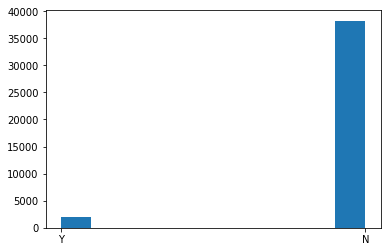

In [60]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert sex to an array using Numpy and plot it using pyplot. 
SatisfactionArr = np.array(data.select('Satisfaction').collect())
plt.hist(SatisfactionArr)
plt.show()

In [61]:
#Performance Evaluation
totalResults = results.select('Satisfaction_Index','prediction')

correctResults = totalResults.filter(totalResults['Satisfaction_Index'] == totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC)) 

Correct: 4072
Total Correct: 4060
